# Web Scraping Craigslist to Lower My Rent

With the continuing drop in rent prices accross San Francisco, and with the financial strain that transitioning careers has left me with , I decided to put my Data Science skills to good use and ask for an evidence based proposal of lowering my rent. This notebook is adapted from Riley Predum's (also a Springboard Data Science grad) [blog post](https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981) about web scraping craigslist using beautiful soup and has been adapted to suit my needs. The end goal of this project is to create a streamlit app that anyone can use to gather information about how their rent compares to the current market.

My situation is this, I currently have a 2 bedroom, 2 bath in the Richmond district of the city (SF) and I'd like to make the case that the average price of comparable units are below what I pay (3500) , that comparable units in my specific neighborhood are also lower,  and that there are a multitude of avalable options below $3500 that are also avalable not restricted to the parameters of my current living situation. This may be wishful thinking, and it is, but the goal is to build a case using any one or number of these options to increase the chances of convincing him.

Let's get to it!

In [211]:
# My specific link is set to only include apartments comparable to mine, 2bed/2bath w/parking
link = 'https://sfbay.craigslist.org/search/sfc/apa?min_bedrooms=2&min_bathrooms=2&availabilityMode=0&parking=1&parking=2&parking=3&parking=4&sale_date=all+dates'

In [212]:
#import get to call a get request on the site
from requests import get

#get the first page of the east bay housing prices
response = get(link)

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
# Posts in the HTML code start with an easy indicator <li "class_result_row", there are 120 to a page
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 120 (elements/page)

<class 'bs4.element.ResultSet'>
120


## Parsing an example post

The goal at this point is to parse out the code extracted from each post. The key info being the neighborhood, number of bedrooms, the price, square feet, the link and post title. Below is an example of the first post from the link.

The breakdown is necessary for each post to create our final dataframe. 

In [117]:
#grab the first post
post_one = posts[0]
post_one

<li class="result-row" data-pid="7232553336" data-repost-of="7221885643">
<a class="result-image gallery" data-ids="3:00N0N_eATCfSHhe9_0An0of,3:01717_kNttY0QjkBe_0An0of,3:00U0U_HMdcZ2P8s7_0An0of,3:00O0O_3RYEEIWHFGr_0An0of,3:00K0K_3Q4Xw3xk7gT_0An0of,3:00000_8HvgtiDhhcv_0An0of,3:00v0v_kCKvj7BGGBh_0An0of,3:01212_h0H6TokaMz3_0An0of,3:00T0T_1eqs8A7K5kA_0Aj0oe,3:01515_kvj4CGhXL0l_0An0of,3:01515_5WIWbYUO3Fo_0Am0of,3:00H0H_ejK3YH101EJ_0An0of,3:00s0s_gH3MPhTmo4B_0Al0oe,3:00101_gTS6GH6Gjiq_0An0of,3:00r0r_boAl6Tk9diP_0An0of,3:00u0u_9rnoNWuUfO6_0An0of,3:00x0x_kKA34pXzpSx_0An0of,3:00G0G_6rBdhoMvtVV_0An0of,3:00D0D_4OUEEMiDpKY_0An0of,3:00D0D_8jq8kf3lVGY_0An0of,3:00606_2FK6DDvmZUU_0Am0of" href="https://sfbay.craigslist.org/sfc/apa/d/san-francisco-bedroom-bath-garden-water/7232553336.html">
<span class="result-price">$6,500</span>
</a>
<div class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" dateti

In [169]:
#grab the price of the first post
post_one_price = post_one.a.text

# This will come in handy later when we append this to our dataframe, we want a stripped down price
post_price = int(post_one_price.strip().replace("$", "").replace(",", ""))
post_price

6500

In [170]:
#grab the time of the post in datetime format to save on cleaning efforts
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']
post_one_datetime

'2020-12-01 11:45'

In [175]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']

#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text
print(post_one_title_text)
print(post_one_link)

3 Bedroom 2 Bath | Garden & Water View | Open Floor - 1065 Montgomery
https://sfbay.craigslist.org/sfc/apa/d/san-francisco-bedroom-bath-garden-water/7232553336.html


In [181]:
#grabs the whole segment of housing details. We will need missing value handling in the loop as this kind of detail is not common in posts
#the text can be split, and we can use indexing to grab the elements we want. number of bedrooms is the first element.
#sqft is the third element

post_one_num_bedrooms = post_one.find('span', class_ = 'housing').text.split()[0]

post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[1][:-3] #cleans the ft2 at the end

In [182]:
print(post_one_num_bedrooms)
print(post_one_sqft)

3br



In [123]:
#the neighborhood is grabbed by finding the span class 'result-hood' and pulling the text element from that
post_one_hood = posts[0].find('span', class_='result-hood').text

In [183]:
print(post_one_hood)

 (north beach / telegraph hill)


## Building the loop

Taking each of these steps together and 

In [195]:
#build out the loop
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')

#pulled the total count of posts as the upper bound of the pages array
results_total = int(results_num.find('span', class_='totalcount').text)

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, 
#and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

#columns
iterations = 0
post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:

    #get request
    # for my situation I want any and all apartments that meet or exceed what I currently have
    # This would be anything greater than a 2bed/2bath and with parking of any kind
    response = get("https://sfbay.craigslist.org/search/sfc/apa?" 
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "&availabilityMode=0"
                   + "&min_bathrooms=2"
                   + '&min_bedrooms=2'
                   + '&parking=1'
                   + '&parking=2'
                   + '&parking=3'
                   + '&parking=4'
                   + '&sale_date=all+dates')

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            #if there is no post price, enter nan value
            for price in post:
                if not post.a.text.strip():
                    post_price = np.nan
                else:
                    post_price = int(post.a.text.strip().replace("$", "").replace(",", ""))
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!


Scrape complete!


In [196]:
import pandas as pd

sf_2bdr_apts = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})
print(sf_2bdr_apts.info())
sf_2bdr_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1287 entries, 0 to 1286
Data columns (total 7 columns):
posted             1287 non-null object
neighborhood       1287 non-null object
post title         1287 non-null object
number bedrooms    1287 non-null object
sqft               737 non-null float64
URL                1287 non-null object
price              1221 non-null float64
dtypes: float64(2), object(5)
memory usage: 70.5+ KB
None


,posted,neighborhood,post title,number bedrooms,sqft,URL,price
0,2020-12-01 11:45,(north beach / telegraph hill),3 Bedroom 2 Bath | Garden & Water View | Open ...,3,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,6500.0
1,2020-12-01 11:43,(SOMA / south beach),**8-Weeks Free! Brand New 2-Bedroom / 2-Bath i...,2,922.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3291.0
2,2020-12-01 11:39,(bayview),Discover Lovely Apartment Living w/ Waterbend!...,2,981.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3010.0
3,2020-12-01 11:38,(richmond / seacliff),2Ba Beautiful & Bright Newly Renovated Apartment,2,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3500.0
4,2020-12-01 11:37,(russian hill),>Charming unfurnished 2x2.5 Apartment Home wit...,2,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,6999.0
5,2020-12-01 11:34,(potrero hill),SPACIOUS Potrero Hill Loft*Tri-Level *3 Br/2.5...,3,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3595.0
6,2020-12-01 11:33,(downtown / civic / van ness),"🎈100VanNess🎈 Your Home Is Waiting|In-Person, S...",2,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3600.0
7,2020-12-01 11:29,(richmond / seacliff),Spacious 3 Bed & 2 Bath By Golden Gate Park & ...,3,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,4999.0
8,2020-12-01 11:28,(downtown / civic / van ness),Elegant CITY PAD ON SPECIAL *150VanNess* 🎉,2,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3092.0
9,2020-12-01 11:23,(potrero hill),LOVELY TRI-LEVEL LOFT * 3 BR / 2.5 BA *Fp *Bal...,3,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3695.0


In [197]:
#first things first, drop duplicate URLs because people are spammy on Craigslist. 
#Let's see how many uniqe posts we really have.
sf_2bdr_apts = sf_2bdr_apts.drop_duplicates(subset='URL')
len(sf_2bdr_apts.drop_duplicates(subset='URL'))

#make the number bedrooms to a float (since np.nan is a float too)
sf_2bdr_apts['number bedrooms'] = sf_2bdr_apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

sf_2bdr_apts['posted'] = pd.to_datetime(sf_2bdr_apts['posted'])

#Looking at what neighborhoods there are with eb_apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

#remove the parenthesis from the left and right of the neighborhoods
sf_2bdr_apts['neighborhood'] = sf_2bdr_apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))

#titlecase them
sf_2bdr_apts['neighborhood'] = sf_2bdr_apts['neighborhood'].str.title()

#just take the first name of the neighborhood list, splitting on the '/' delimiter
sf_2bdr_apts['neighborhood'] = sf_2bdr_apts['neighborhood'].apply(lambda x: x.split('/')[0])

#fix one-offs that
#sf_2bdr_apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#sf_2bdr_apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)

#remove whitespaces
#sf_2bdr_apts['neighborhood'] = sf_2bdr_apts['neighborhood'].apply(lambda x: x.strip())

In [198]:
sf_2bdr_apts['neighborhood'] = sf_2bdr_apts['neighborhood'].map(lambda x: x.replace('(', ''))

In [199]:
print(sf_2bdr_apts.info())
sf_2bdr_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 0 to 116
Data columns (total 7 columns):
posted             117 non-null datetime64[ns]
neighborhood       117 non-null object
post title         117 non-null object
number bedrooms    117 non-null float64
sqft               67 non-null float64
URL                117 non-null object
price              111 non-null float64
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 7.3+ KB
None


,posted,neighborhood,post title,number bedrooms,sqft,URL,price
0,2020-12-01 11:45:00,North Beach,3 Bedroom 2 Bath | Garden & Water View | Open ...,3.0,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,6500.0
1,2020-12-01 11:43:00,Soma,**8-Weeks Free! Brand New 2-Bedroom / 2-Bath i...,2.0,922.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3291.0
2,2020-12-01 11:39:00,Bayview,Discover Lovely Apartment Living w/ Waterbend!...,2.0,981.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3010.0
3,2020-12-01 11:38:00,Richmond,2Ba Beautiful & Bright Newly Renovated Apartment,2.0,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3500.0
4,2020-12-01 11:37:00,Russian Hill,>Charming unfurnished 2x2.5 Apartment Home wit...,2.0,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,6999.0
5,2020-12-01 11:34:00,Potrero Hill,SPACIOUS Potrero Hill Loft*Tri-Level *3 Br/2.5...,3.0,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3595.0
6,2020-12-01 11:33:00,Downtown,"🎈100VanNess🎈 Your Home Is Waiting|In-Person, S...",2.0,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3600.0
7,2020-12-01 11:29:00,Richmond,Spacious 3 Bed & 2 Bath By Golden Gate Park & ...,3.0,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,4999.0
8,2020-12-01 11:28:00,Downtown,Elegant CITY PAD ON SPECIAL *150VanNess* 🎉,2.0,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3092.0
9,2020-12-01 11:23:00,Potrero Hill,LOVELY TRI-LEVEL LOFT * 3 BR / 2.5 BA *Fp *Bal...,3.0,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3695.0


In [218]:
# let's get the URL's for the missing prices and inspect
for url in  range(len(sf_2bdr_apts[sf_2bdr_apts['price'].isnull()]['URL'])):
    print(sf_2bdr_apts[sf_2bdr_apts['price'].isnull()]['URL'].iloc[url])

https://sfbay.craigslist.org/sfc/apa/d/san-francisco-large-bedroom-with-full/7239990098.html
https://sfbay.craigslist.org/sfc/apa/d/san-francisco-channel-park-views-right/7239939793.html
https://sfbay.craigslist.org/sfc/apa/d/san-francisco-live-the-mission-bay/7239921159.html
https://sfbay.craigslist.org/sfc/apa/d/san-francisco-live-the-mission-bay/7239908539.html
https://sfbay.craigslist.org/sfc/apa/d/san-francisco-2ba-beautiful-lg-rear/7233633144.html
https://sfbay.craigslist.org/sfc/apa/d/san-francisco-th-ave-freshly-painted-2/7234018955.html


In [224]:
# I couldn't quite parse out the prices without visiting the sites, this will have to work for now
# the prices, in order are in the list below, let's use this to replace the missing prices.
prices = np.array([3500, 3660, 3793, 3896, 3950, 3600])

for row, entry in zip(sf_2bdr_apts.loc[sf_2bdr_apts['price'].isnull(), 'price'].index, prices):
    sf_2bdr_apts.at[row, 'price'] = entry

In [225]:
print(sf_2bdr_apts.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 0 to 116
Data columns (total 7 columns):
posted             117 non-null datetime64[ns]
neighborhood       117 non-null object
post title         117 non-null object
number bedrooms    117 non-null float64
sqft               67 non-null float64
URL                117 non-null object
price              117 non-null float64
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 12.3+ KB
None


In [226]:
sf_2bdr_apts.neighborhood.unique()

array([' North Beach ', ' Soma ', ' Bayview', ' Richmond ',
       ' Russian Hill', ' Potrero Hill', ' Downtown ', ' Alamo Square ',
       ' Pacific Heights', ' Inner Sunset ', ' Cole Valley ',
       ' Ingleside ', ' Castro ', ' Hayes Valley', ' Panhandle',
       ' Nob Hill', ' Lower Pac Hts', ' Bernal Heights', ' Noe Valley',
       ' Mission District', ' Glen Park', ' Inner Richmond', ' Usf ',
       ' Sunset ', ' West Portal ', ' Lower Haight', ' San Lorenzo, Ca',
       ' Marina ', ' Portola District', ' Fair Oaks'], dtype=object)

In [228]:
sf_2bdr_apts[(sf_2bdr_apts['neighborhood'] == ' San Lorenzo, Ca') | 
             (sf_2bdr_apts['neighborhood'] == ' Fair Oaks')]

,posted,neighborhood,post title,number bedrooms,sqft,URL,price
94,2020-12-01 07:45:00,"San Lorenzo, Ca",Mostly furnished home. One queen size bed in m...,3.0,1164.0,https://sfbay.craigslist.org/sfc/apa/d/san-lea...,1400.0
111,2020-12-01 00:17:00,Fair Oaks,****Sac Area***-3bed 2.5 Bath 1600s.f Townhouse,3.0,1600.0,https://sfbay.craigslist.org/sfc/apa/d/fair-oa...,2250.0


In [229]:
# let's call it what it is here
sf_2bdr_apts['neighborhood'] = sf_2bdr_apts['neighborhood'].replace([' Downtown '], ' Soma')

In [230]:
# drop non-sf locations
sf_2bdr_apts = sf_2bdr_apts.drop(index=[94, 111]).reset_index(drop=True)

In [231]:
# save to a df for later use
sf_2bdr_apts.to_csv('sf_apts_12_1', index = 0)

## Quick Analysis

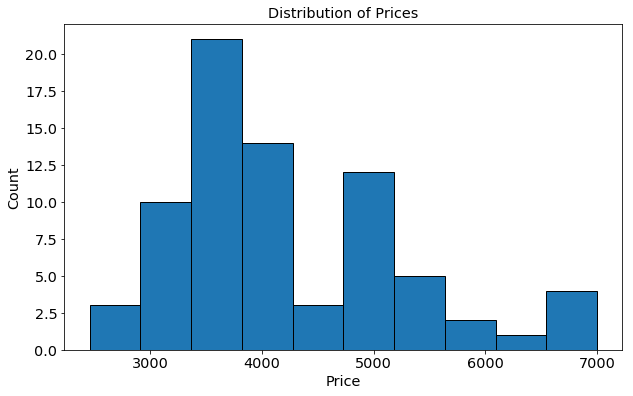

In [238]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

two_bdrms = sf_2bdr_apts[sf_2bdr_apts['number bedrooms'] == 2]

plt.figure(figsize=(10, 6))
plt.hist(two_bdrms['price'], edgecolor='black');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Prices");

In [284]:
#group by neighborhood
two_bdrms.groupby('neighborhood')['price'].mean().sort_values()

neighborhood
 Lower Pac Hts       2935.000000
 Marina              2995.000000
 Bayview             3010.000000
 Soma                3248.200000
 Glen Park           3350.000000
 Richmond            3500.000000
 Ingleside           3500.000000
 Inner Sunset        3500.000000
 Sunset              3600.000000
 North Beach         3650.000000
 Castro              3658.333333
 Panhandle           3690.000000
 Mission District    3973.500000
 Potrero Hill        4056.285714
 Soma                4230.103448
 Noe Valley          4800.000000
 Pacific Heights     5334.375000
 Russian Hill        5388.200000
 Cole Valley         5750.000000
Name: price, dtype: float64

In [285]:
#group by neighborhood
two_bdrms.groupby('neighborhood')['price'].mean().mean()

3903.6314471523633

> It looks like the Richmond District is right there at the average I currently pay and the average city wide is about $400 greater as well.

In [286]:
below_rent = sf_2bdr_apts[sf_2bdr_apts['price'] <= 3500]

In [289]:
#group by neighborhood
below_rent.groupby('neighborhood')[['number bedrooms', 'price']].mean().sort_values(by='price')

,number bedrooms,price
neighborhood,,
Potrero Hill,2.000,2459.000000
Lower Pac Hts,2.000,2935.000000
Soma,2.000,2947.333333
Marina,2.000,2995.000000
Bayview,2.000,3010.000000
Soma,2.125,3217.000000
Castro,2.000,3275.000000
Glen Park,2.000,3350.000000
Mission District,2.000,3350.000000


It looks like the only neighborhood with the potential for greater value for 3500 or less is SOMA. 

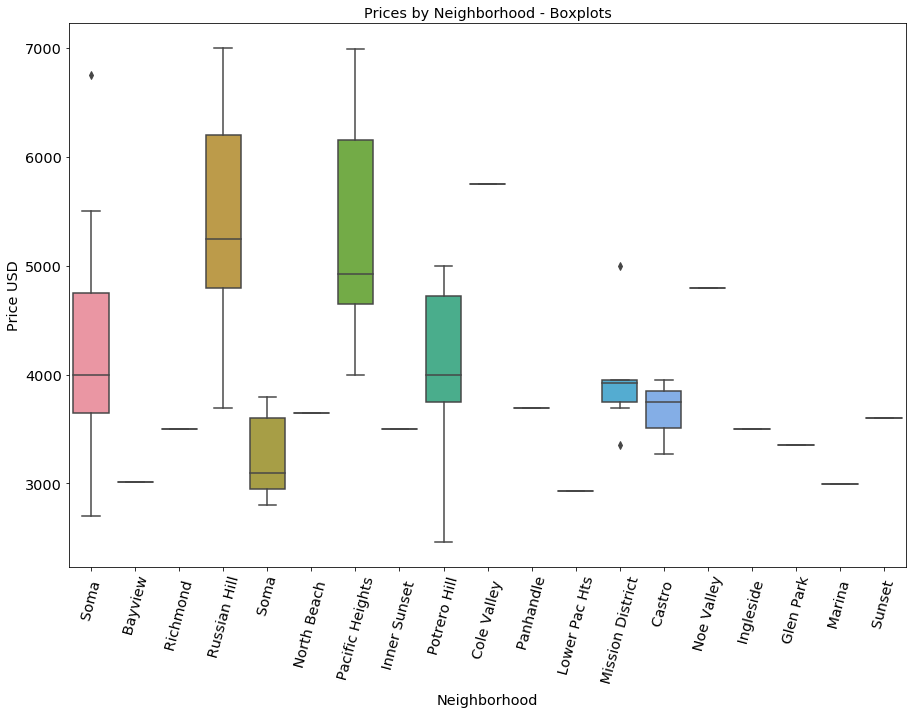

In [254]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='neighborhood', y='price', data=two_bdrms)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");

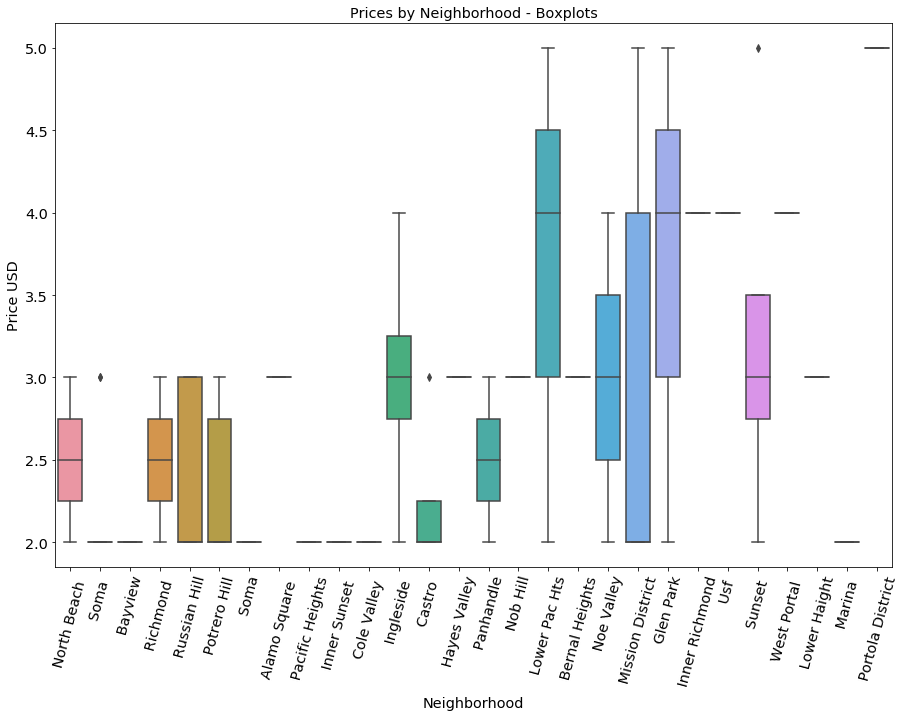

In [290]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='neighborhood', y='number bedrooms', data=sf_2bdr_apts)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Bedrooms by Neighborhood - Boxplots");

It appears that there is limited data right now on 2bedroom apartments. There is only one posting of a 2bed/2bath in my neighborhood, let's collect about a months worth of data and concat them for analysis later.